We use `pyfst`, a pyhton wrapper for the great openfst library. Thanks to Victor Chahuneau for the wrapper (check it on github).

In [8]:
import fst


# Helper code

In [9]:
# Let's see the input as a simple linear chain FSA
def make_input(srcstr, sigma = None):
    """
    converts a nonempty string into a linear chain acceptor
    @param srcstr is a nonempty string
    @param sigma is the source vocabulary
    """
    assert(srcstr.split())
    return fst.linear_chain(srcstr.split(), sigma)

In [10]:
def parse_rule(rulestr, table = None):
    rule = [field.strip().split() for field in rulestr.split('|||')]
    if table is not None:
        table.append(rule)
    return rule


In [11]:
ruletable = []
parse_rule('A ||| a', ruletable)
parse_rule('B ||| b', ruletable)
parse_rule('C ||| c', ruletable)
parse_rule('A C ||| d', ruletable)
parse_rule('D ||| d e', ruletable)
parse_rule('C D E ||| d c e', ruletable)
ruletable

[[['A'], ['a']],
 [['B'], ['b']],
 [['C'], ['c']],
 [['A', 'C'], ['d']],
 [['D'], ['d', 'e']],
 [['C', 'D', 'E'], ['d', 'c', 'e']]]

In [12]:
import itertools
def make_rules(rules, sigma = None, delta = None):
    """
    This procedure creates a transducer with all rules in the rule table.
    It isn't optimised to produce minimal transducers.
    """
    R = fst.Transducer(isyms = sigma, osyms = delta)
    n = 1 # next non-initial state  
    for rule in rules:
        fphrase, ephrase = rule[0], rule[1]
        longest = max(len(fphrase), len(ephrase))
        # the phrases are represented from 0 (initial) to 0 (accepting)
        # the states in the middle depend on the value of n and on the length of the longest phrase
        states = [0] + range(n, n + longest)
        states[-1] = 0
        # create the arcs
        # print R.isyms.find(0) # ε
        fphrase = tuple(x.encode('utf-8') for x in fphrase)
        ephrase = tuple(x.encode('utf-8') for x in ephrase)
        #print fphrase
        #print ephrase
        #print fst.EPSILON.encode('utf-8')
        [R.add_arc(states[i], states[i+1], fe[0], fe[1], 0) for i, fe in enumerate(itertools.izip_longest(fphrase, ephrase, fillvalue=fst.EPSILON))]
        # updates n (except for single words -- they don't require extra states)
        n += longest - 1
    R[0].initial = True
    R[0].final = 0
    return R

In [13]:
R = make_rules(ruletable)

In [14]:
R


UnicodeDecodeError: 'ascii' codec can't decode byte 0xce in position 5013: ordinal not in range(128)

In [15]:
# I am going to start with a very simple wrapper for a python dictionary that
# will help us associate unique ids to items
# this wrapper simply offers one aditional method (insert) similar to the insert method of an std::map
class ItemFactory(object):
    
    def __init__(self):
        self.nextid_ = 0
        self.i2s_ = {}
        
    def insert(self, item):
        """
        Inserts a previously unmapped item.
        Returns the item's unique id and a flag with the result of the intertion.
        """
        uid = self.i2s_.get(item, None)
        if uid is None:
            uid = self.nextid_
            self.nextid_ += 1
            self.i2s_[item] = uid
            return uid, True
        return uid, False
    
    def get(self, item):
        """
        Returns the item's unique id (assumes the item has been mapped before)
        """
        return self.i2s_[item]

In [16]:
# Let's define a model of translational equivalences that performs word replacement of arbitrary permutations of the input
# constrained to a window of length $d$ (see WLd in (Lopez, 2009)) 
# same strategy in Moses (for phrase-based models)
def WLdPermutations(sentence, d = 2, sigma = None, delta = None):
    from collections import deque
    from itertools import takewhile
    A = fst.Transducer(isyms = sigma, osyms = delta)
    I = len(sentence)
    axiom = (1, tuple([False]*min(I - 1, d - 1)))
    ifactory = ItemFactory()
    ifactory.insert(axiom)
    Q = deque([axiom])
    while Q:
        ant = Q.popleft() # antecedent
        l, C = ant # signature
        sfrom = ifactory.get(ant) # state id
        if l == I + 1: # goal item
            A[sfrom].final = 0 # is a final node
            continue
        # adjacent
        n = 0 if (len(C) == 0 or not C[0]) else sum(takewhile(lambda b : b, C)) # leading ones
        ll = l + n + 1
        CC = list(C[n+1:])
        maxlen = min(I - ll, d - 1)
        if maxlen:
            m = maxlen - len(CC) # missing positions
            [CC.append(False) for _ in range(m)]
        cons = (ll, tuple(CC))
        sto, inserted = ifactory.insert(cons)
        if inserted:
            Q.append(cons)
        A.add_arc(sfrom, sto, str(l), sentence[l-1], 0)
        # non-adjacent
        ll = l
        for i in range(l + 1, I + 1):
            if i - l + 1 > d: # beyond limit
                break
            if C[i - l - 1]: # already used
                continue
            # free position
            CC = list(C)
            CC[i-l-1] = True
            cons = (ll, tuple(CC))
            sto, inserted = ifactory.insert(cons)
            if inserted:
                Q.append(cons)
            A.add_arc(sfrom, sto, str(i), sentence[i-1], 0)
    return A   

# Input

`sigma` and `delta` are the source and target vocabulary, respectively.

In [17]:
# Let's create a table for the input vocabulary $\Sigma$
sigma = fst.SymbolTable()
# and for the output vocabulary $\Delta$
delta = fst.SymbolTable()

the input consists in a linear-chain automaton (implemented as a self-transducer)

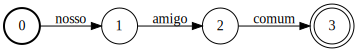

In [18]:
# Let's have a look at the input as an automaton
# we call it F ('f' is the cannonical source language)
ex1_F = make_input('nosso amigo comum', sigma)
ex1_F

# Rule table

Set of known bilingual mappings (word-to-word or phrase-to-phrase).

In [19]:
# this is how we parse rules 
# for now let's use word-to-word mappings
ex1_table = []
parse_rule('nosso ||| our', ex1_table)
parse_rule('nosso ||| ours', ex1_table)
parse_rule('amigo ||| friend', ex1_table)
parse_rule('amigo ||| mate', ex1_table)
parse_rule('comum ||| ordinary', ex1_table)
parse_rule('comum ||| mutual', ex1_table)
parse_rule('comum ||| common', ex1_table)
parse_rule('comum ||| usual', ex1_table)
ex1_table

[[['nosso'], ['our']],
 [['nosso'], ['ours']],
 [['amigo'], ['friend']],
 [['amigo'], ['mate']],
 [['comum'], ['ordinary']],
 [['comum'], ['mutual']],
 [['comum'], ['common']],
 [['comum'], ['usual']]]

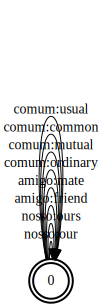

In [20]:
# Let's call G the automaton that represents the phrase table (G for 'grammar' due to connection to CFG models)
ex1_G = make_rules(ex1_table)
ex1_G

# Monotone word-replacement model

For a simple monotone word-replacement model, the automaton G matches our model of translational equivalences exactly.

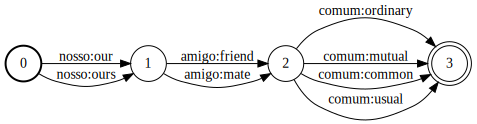

In [21]:
# The composition defines the space of all sentence pairs whose input is F
ex1_E = ex1_F >> ex1_G
ex1_E

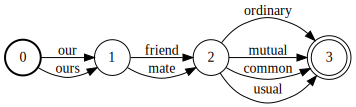

In [22]:
# a projection lets us focus on target strings only
ex1_E.project_output()
ex1_E

# Permutations
Monotone translation is not all that interesting.
Let's explore some strategies for word reordering.

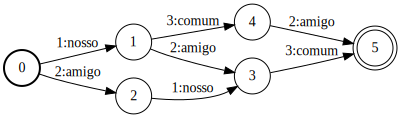

In [23]:
# these are the permutations of the input according to WL$2$
ex1_WLd2 = WLdPermutations('nosso amigo comum'.split(), 2, None, sigma)
ex1_WLd2

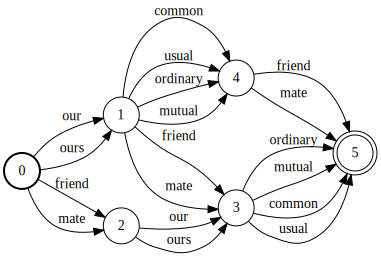

In [24]:
# The translations defined by the extended model can be found via composition with R
ex1_E = ex1_WLd2 >> ex1_G
ex1_E.project_output()
ex1_E

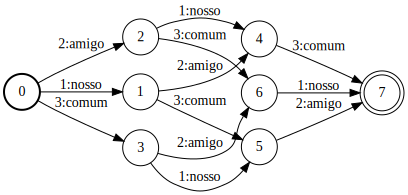

In [25]:
# these are in fact all permutations (because I = d = 3)
ex1_WLd3 = WLdPermutations('nosso amigo comum'.split(), 3, None, sigma)
ex1_WLd3

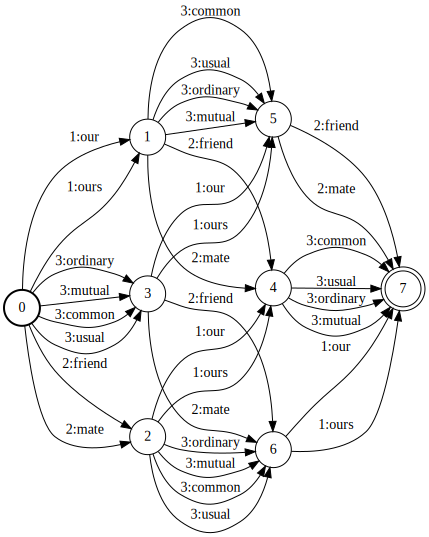

In [26]:
# and these are all solutions with d=3
ex1_WLd3 >> ex1_G

# Phrase-based 
It is straightforward to use phrase mappings rather than word mappings.

Implementing the model in Moses strictly requires adapting WLd to permute source phrases and project target phrases directly. Simply running WLd on the input and intersecting with the phrase based grammar can result in discountiguous parts of the input beeing covered by a contiguous phrase.
Example: `a b c d e` can be permuted into `a c b d e` by WLd3, and a phrase pair `a c => x y` might exist. However, phrase-based MT in its standard formulation would not allow that. Let's disregard that for now.

In [21]:
# let's add two biphrases that account for some local reordering
ex2_table = list(ex1_table)
parse_rule('amigo comum ||| mutual friend', ex2_table)
parse_rule('nosso amigo ||| our friend', ex2_table)
ex2_table

[[['nosso'], ['our']],
 [['nosso'], ['ours']],
 [['amigo'], ['friend']],
 [['amigo'], ['mate']],
 [['comum'], ['ordinary']],
 [['comum'], ['mutual']],
 [['comum'], ['common']],
 [['comum'], ['usual']],
 [['amigo', 'comum'], ['mutual', 'friend']],
 [['nosso', 'amigo'], ['our', 'friend']]]

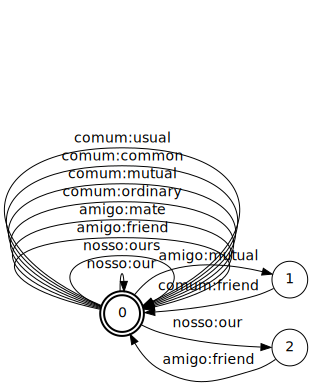

In [22]:
ex2_G = make_rules(ex2_table, sigma, delta)
ex2_G


Having those two biphrases taking care of local reordering, the monotone model can produce the correct translation `our mutual friend`

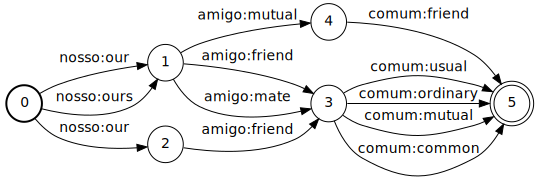

In [23]:
ex1_F >> ex2_G

Obviously, we can also use the more general WLd2 model.

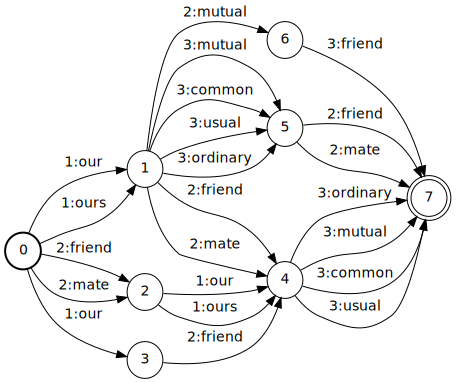

In [24]:
ex1_WLd2 >> ex2_G

In [25]:
def make_ngram(ngrams, delta):
    pass

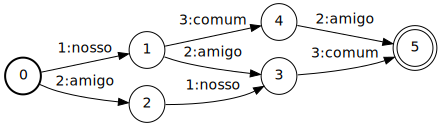

In [36]:
nac_F = WLdPermutations('nosso amigo comum'.split(), 2, None, sigma)
nac_F

In [37]:
nac_table = []
parse_rule('nosso ||| our', nac_table)
parse_rule('amigo ||| friend', nac_table)
parse_rule('comum ||| common', nac_table)
parse_rule('comum ||| mutual', nac_table)
parse_rule('comum ||| ordinary', nac_table)
parse_rule('amigo comum ||| mutual friend', nac_table)
nac_table

[[['nosso'], ['our']],
 [['amigo'], ['friend']],
 [['comum'], ['common']],
 [['comum'], ['mutual']],
 [['comum'], ['ordinary']],
 [['amigo', 'comum'], ['mutual', 'friend']]]

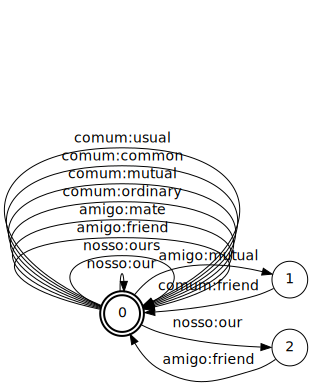

In [33]:
nac_G = make_rules(ex2_table, sigma, delta)
nac_G

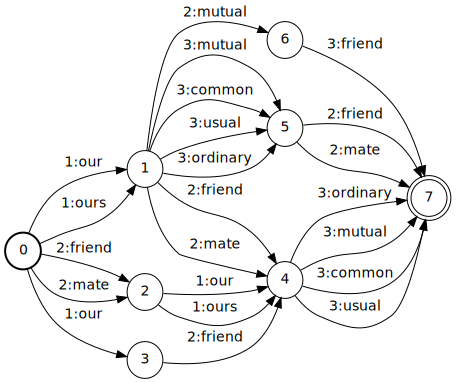

In [34]:
nac_F >> nac_G